<a href="https://colab.research.google.com/github/FabriDeCastelli/ISPR-23-24/blob/main/assignment2/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Restricted Boltzmann Machine

## Author: Fabrizio De Castelli

In [ ]:
import os
import keras as K
from sklearn.model_selection import train_test_split

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# comment all the following lines if run in local
current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

!git clone https://github.com/FabriDeCastelli/ISPR-23-24.git
os.chdir("ISPR-23-24/assignment2")

# until here

# ------- GLOBAL VARIABLES -------
# MNIST dataset
MNIST_TRAINING_IMAGES_PATH = "dataset/train-images.idx3-ubyte"
MNIST_TRAINING_LABELS_PATH = "dataset/train-labels.idx1-ubyte"
MNIST_TEST_IMAGES_PATH = "dataset/t10k-images.idx3-ubyte"
MNIST_TEST_LABELS_PATH = "dataset/t10k-labels.idx1-ubyte"


## Restricted Boltzmann Machine

In this implementation it is provided a class that implements a Restricted Boltzmann Machine (RBM). It incorporates the Contrastive Divergence algorithm to train the model, with a parameter $k$, to control the number of forward and backward steps. The default value is $k=1$ as required by the instructions, to implement CD-1.
### Design Choices
- Glorot initialization for weights.
- Zeros initialization for both hidden and visible biases.
- Online, mini-batch and batch training with a learning rate that is normalized by the batch size. If the parameter batch_size in the fit method is not provided, the model will default to batch training.
- Energy and error tracking across epochs
- Model (weights and biases) saving and loading (.npz format). The class method from_components allows to create an instance of the RBM from the components saved in a file.
- Utilities for plotting the components, the energy and the original and reconstructed images.

All the methods are implemented in the class RestrictedBoltzmannMachine. Brief descriptions of the methods are provided in the docstrings.

In [ ]:
class RestrictedBoltzmannMachine:
    """
    Restricted Boltzmann Machine implementation.
    """

    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        # glorot initialization for weights
        self.weights = np.random.randn(num_hidden, num_visible) * np.sqrt(6 / (num_hidden + num_visible))
        # zeros initialization for biases
        self.hidden_bias = np.zeros((num_hidden, 1))
        self.visible_bias = np.zeros((num_visible, 1))
        self.energy_record = []
        self.average_energy_record = []
        self.learning_rate = 0.1

    @classmethod
    def from_components(cls, path):
        """
        Creates a RestrictedBoltzmannMachine instance from the components saved in a file.

        :param path: path to the file
        :return: an instance of RestrictedBoltzmannMachine
        """
        with np.load(path) as f:
            weights = f['weights']
            hidden_bias = f['hidden_bias']
            visible_bias = f['visible_bias']
        rmb = cls(weights.shape[1], weights.shape[0])
        rmb.weights = weights
        rmb.hidden_bias = hidden_bias
        rmb.visible_bias = visible_bias
        return rmb

    def contrastive_divergence(self, k, v0):
        """
        Performs k steps of the Contrastive Divergence algorithm.
        In this method the model parameters are updated.

        :param k: the number of steps
        :param v0: the visible input after binarization
        :return: the error and the reconstructed data
        """

        positive_hidden_probabilities = None
        reconstructed_data = v0
        negative_hidden_probabilities = None

        for _ in range(k):

            # Positive phase
            positive_hidden_probabilities = self.sample_hidden(reconstructed_data) # [m, batch_size]
            positive_hidden_stochastic = RestrictedBoltzmannMachine.binarize(positive_hidden_probabilities) # [m, batch_size]
            data_reconstruction_probability = self.sample_visible(positive_hidden_stochastic) # [n, batch_size]

            # Negative phase
            reconstructed_data = RestrictedBoltzmannMachine.binarize(data_reconstruction_probability) # [n, batch_size]
            negative_hidden_probabilities = self.sample_hidden(reconstructed_data) # [m, batch_size]

        self.energy_record.append(self.energy(reconstructed_data, negative_hidden_probabilities))

        wake = np.dot(positive_hidden_probabilities, v0)
        dream = np.dot(negative_hidden_probabilities, reconstructed_data)

        dW = wake - dream
        dhb = (positive_hidden_probabilities - negative_hidden_probabilities).sum(axis=1).reshape(-1, 1)
        dvb = (v0 - reconstructed_data).sum(axis=0).reshape(-1, 1)

        error = np.mean(np.square(v0 - reconstructed_data))

        self.weights = self.weights + self.learning_rate * dW
        self.hidden_bias = self.hidden_bias + self.learning_rate * dhb
        self.visible_bias = self.visible_bias + self.learning_rate * dvb

        return error, reconstructed_data

    def fit(self, data, epochs, k=1, learning_rate=0.1, batch_size=None, verbose=False):
        """
        Fits the RBM to the data.

        :param data: the input examples
        :param epochs: number of epochs
        :param k: the number of steps in the contrastive divergence
        :param learning_rate: the learning rate
        :param batch_size: the batch size
        :param verbose: whether to print the error at each epoch
        """

        if batch_size is None:
            batch_size = len(data)
        error = 0

        self.learning_rate = learning_rate / batch_size

        for epoch in range(epochs):

            np.random.shuffle(data)
            self.energy_record = []

            for i in range(len(data) // batch_size):

                batch = data[i * batch_size: (i + 1) * batch_size]
                binarized_inputs = RestrictedBoltzmannMachine.binarize(batch)
                error, _ = self.contrastive_divergence(k, binarized_inputs)

            self.average_energy_record.append(np.mean(self.energy_record))

            if verbose:
                print(f'Epoch: {epoch + 1}, Error: {error}, Average Energy: {self.average_energy_record[-1]}')


    def energy(self, v, h):
        """
        Computes the energy of the RBM.

        :param v: the visible layer
        :param h: the hidden layer
        :return: the energy
        """
        return -np.dot(v, self.visible_bias).sum() - np.dot(h.T, self.hidden_bias).sum() - np.dot(np.dot(v, self.weights.T), h).sum()

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def sample_hidden(self, visible):
        """
        Samples the hidden layer given the visible layer.

        :param visible: the visible layer
        :return: the hidden activations
        """
        return RestrictedBoltzmannMachine.sigmoid(np.add(np.dot(self.weights, visible.T), self.hidden_bias))

    def sample_visible(self, hidden):
        """
        Samples the visible layer given the hidden layer.

        :param hidden: the hidden layer
        :return: the visible activations
        """
        return RestrictedBoltzmannMachine.sigmoid(np.add(np.dot(hidden.T, self.weights), self.visible_bias.T))

    @staticmethod
    def binarize(data):
        return (data > np.random.rand(*data.shape)).astype(int)


    def predict_hidden(self, data):
        """
        Predicts the hidden layer activations given the input data.

        :param data: the input data
        :return: the hidden layer activations
        """

        v1 = self.predict(data)
        h1 = self.sample_hidden(v1)
        return h1.T

    def predict(self, data, plot=False):
        """
        Predicts the visible layer activations given the input data.

        :param data: the input data
        :param plot: whether to plot the original and reconstructed images
        :return: the visible layer activations
        """
        if len(data.shape) == 1:
            data = data.reshape(1, -1)

        v0 = RestrictedBoltzmannMachine.binarize(data)
        positive_hidden_probabilities = self.sample_hidden(v0)
        positive_hidden_stochastic = RestrictedBoltzmannMachine.binarize(positive_hidden_probabilities)
        data_reconstruction_probability = self.sample_visible(positive_hidden_stochastic)
        v1 = RestrictedBoltzmannMachine.binarize(data_reconstruction_probability)

        if plot:
            RestrictedBoltzmannMachine.plot_reconstructed_images(v0, v1)

        return v1

    # ---------- Serialization and Plotting -----------
    def save(self, path='model/rbm.npz'):
        """
        Saves the model to a file.

        :param path: the path to the file
        """
        if not os.path.exists('model'):
            os.makedirs('model')
        np.savez(path, weights=self.weights, hidden_bias=self.hidden_bias, visible_bias=self.visible_bias)

    def plot_components(self):
        """
        Plots the components extracted by the RBM.
        """
        plt.figure(figsize=(20, 20))
        for i in range(self.num_hidden):
            plt.subplot(10, 10, i + 1)
            plt.imshow(self.weights[i].reshape((28, 28)),
                       interpolation='nearest', vmin=-2.5, vmax=2.5)
            plt.axis('off')
        plt.suptitle(f'{self.num_hidden} components extracted by RBM', fontsize=16)

    @staticmethod
    def plot_reconstructed_images(data, reconstruction):
        """
        Plots the original and reconstructed images.

        :param data: the input data
        :param reconstruction: the reconstructed data
        """
        num_images = len(data)
        num_cols = 10
        num_rows = (num_images // num_cols) + (num_images % num_cols > 0)
        fig, axs = plt.subplots(nrows=num_rows + 1, ncols=num_cols, figsize=(15, 5 * num_rows))

        fig.suptitle('Original and Reconstructed Images', fontsize=16)
        fig.text(0.5, 0.84, 'Original Images', ha='center', fontsize=14)
        for i, ax in enumerate(axs.flat):
            if i >= num_images:
                ax.axis('off')
                continue
            ax.imshow(data[i].reshape(28, 28))
            ax.axis('off')

        fig.text(0.5, 0.42, 'Reconstructed Images', ha='center', fontsize=14)

        for i, ax in enumerate(axs.flat[num_images:]):
            ax.imshow(reconstruction[i].reshape(28, 28))
            ax.axis('off')

        plt.show()

    def plot_energy(self):
        """
        Plots the energy history of the RBM.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.average_energy_record)
        plt.title('Energy of the RBM')
        plt.xlabel('Iterations')
        plt.ylabel('Energy')
        plt.show()


#### Utility to load the MNIST dataset
Can specify the set to load: either 'training' or 'test'. This function provides the labels and the images.

In [ ]:
def mnist(_set='training'):
    """
    Loads the MNIST dataset.

    :param _set: the set to load (either 'training' or 'test')
    :return: the images and the labels
    """

    if _set == 'training':
        images = MNIST_TRAINING_IMAGES_PATH
        labels = MNIST_TRAINING_LABELS_PATH
    elif _set == 'test':
        images = MNIST_TEST_IMAGES_PATH
        labels = MNIST_TEST_LABELS_PATH
    else:
        raise ValueError('Invalid set: provide either "training" or "test"')

    with open(images, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)

    with open(labels, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        _ = int.from_bytes(f.read(4), 'big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)

    return data, labels

## Training the RBM on MNIST
The RBM is trained on the MNIST dataset with 50 hidden units. After some trial and error, hyperparameters such as the learning rate, the number of epochs and the batch size have been chosen and set to 0.17, 25 and 100.

Following the instructions from _A Practical Guide to Training Restricted Boltzmann Machines_ ([link here](http://www.cs.toronto.edu/%7Ehinton/absps/guideTR.pdf)), the reconstruction error was not considered as a steady metric to evaluate the training. We expect a rapid decrease in the first epochs and then fluctuations due to the noise introduced by the mini-batches. Fluctuations are expected and do not necessarily indicate that the model is not learning, as the function that is optimized in CD-1 is not the reconstruction error. To have more information about the training progress and the model performance, the average energy (over mini-batches) of the RBM is plotted across epochs. The energy is defined as:
$$
E(v, h) = -v^TWh - b^Tv - c^Th
$$
where $v$ is the visible layer, $h$ is the hidden layer, $W$ is the weights matrix, $b$ is the visible bias and $c$ is the hidden bias. The energy is a measure of the compatibility between the visible and hidden units.

In [ ]:
x_train, _ = mnist('training')
rbm = RestrictedBoltzmannMachine(x_train.shape[1], 50)
rbm.fit(np.copy(x_train), epochs=30, k=1, learning_rate=0.17, batch_size=100, verbose=True)
rbm.save()

Epoch: 1, Error: 0.09941326530612245, Average Energy: -137608.7315907023
Epoch: 2, Error: 0.08849489795918368, Average Energy: -47730.69513648952
Epoch: 3, Error: 0.08219387755102041, Average Energy: -40953.53385264789
Epoch: 4, Error: 0.07798469387755103, Average Energy: -48531.45893820043
Epoch: 5, Error: 0.07642857142857143, Average Energy: -59305.9986273928
Epoch: 6, Error: 0.08063775510204081, Average Energy: -87020.25032829911
Epoch: 7, Error: 0.07262755102040816, Average Energy: -112393.89997764063
Epoch: 8, Error: 0.07873724489795918, Average Energy: -151454.14115290387
Epoch: 9, Error: 0.0764923469387755, Average Energy: -187692.28625201428
Epoch: 10, Error: 0.08315051020408164, Average Energy: -222394.4705749373
Epoch: 11, Error: 0.0760204081632653, Average Energy: -262423.94464395306
Epoch: 12, Error: 0.07244897959183673, Average Energy: -293299.50677818246
Epoch: 13, Error: 0.07502551020408163, Average Energy: -334254.59751213924
Epoch: 14, Error: 0.0754719387755102, Averag

## Plots

### Energy
The plot shows that average energy of the RBM smoothly decreases across epochs, indicating that the model is learning. The initial peak is due to the random initialization of the weights and biases.

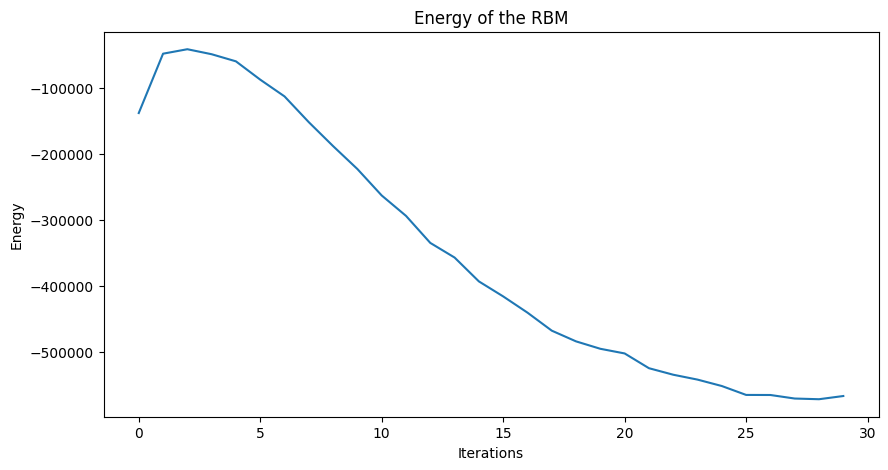

In [ ]:
rbm.plot_energy()

### Reconstructed Images

The plot shows the original and reconstructed images. The reconstructed images are obtained by feeding the original images to the RBM and then sampling the visible layer. The images are binarized, so the reconstructed images are not perfect, but they are a good approximation of the original ones. They are not as sharp as the original images, but the reconstruction is good enough to recognize the digits.

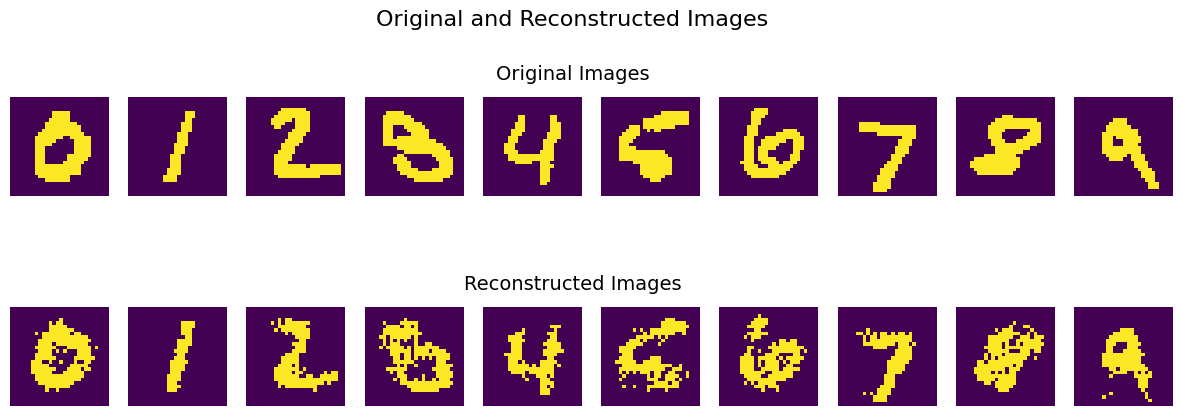

In [ ]:
x_test, y_test = mnist('test')
_, indices = np.unique(y_test, return_index=True)
rbm = RestrictedBoltzmannMachine.from_components('model/rbm.npz')
pred = rbm.predict(x_test[indices], plot=True)


## Components

The plot shows the components extracted by the RBM. Each component is a 28x28 image that represents the weights of the hidden units and can be interpreted as a feature that the model has learned. Of course, setting the number of components (number of hidden neurons) to a higher number might bring the model to reconstruct the images better, but it would also make the training process slower.

It can be noticed how some of the figures below are somehow attributable to the original digits, while others are more abstract.
For instance the component number 32 is a sort of "1" digit, while the component number 10 is more a "0"-shaped image. The other components are more abstract and do not resemble any digit in particular, but they are still useful for the model.

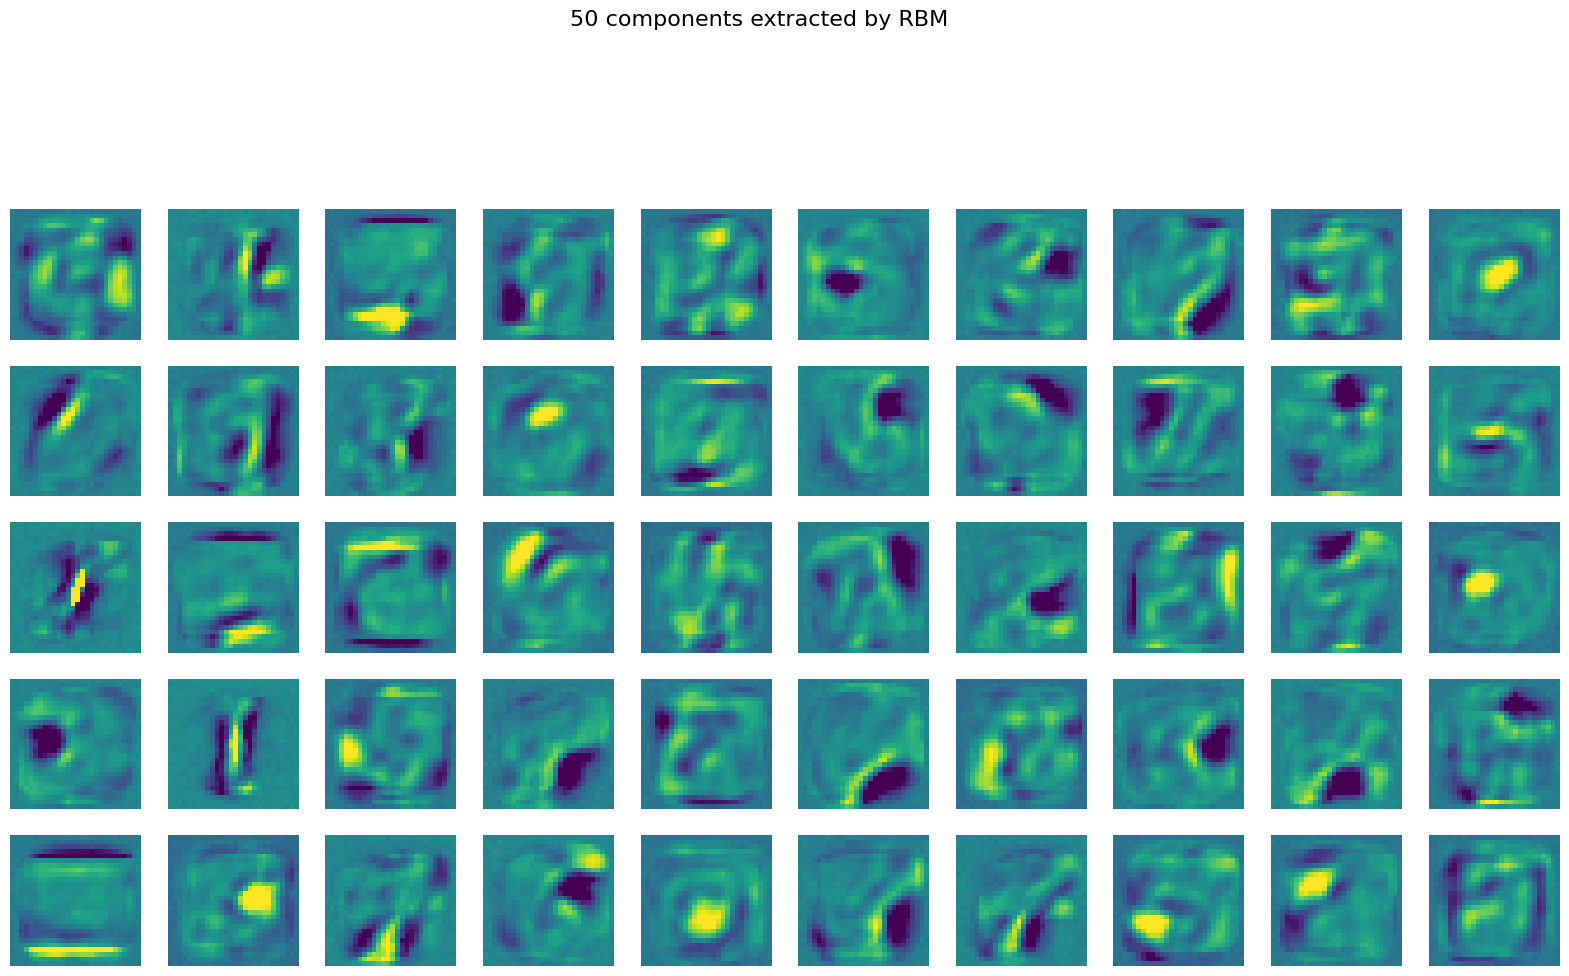

In [ ]:
rbm.plot_components()

## Classification with a Feed Forward Neural Network

We use a three hidden layers neural network as simple architecture to perform classification on the hidden features extracted by the RBM. The network is trained on the encoded training set and tested on the encoded test set in a hold-out fashion. Early stopping callback is used to prevent overfitting in the training phase.


In [ ]:
feed_forward = K.models.Sequential()
feed_forward.add(K.layers.Dense(256, input_dim=50, activation='relu'))
feed_forward.add(K.layers.Dense(128, activation='relu'))
feed_forward.add(K.layers.Dense(64, activation='relu'))
feed_forward.add(K.layers.Dense(10, activation='softmax'))
feed_forward.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
feed_forward.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               13056     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 54858 (214.29 KB)
Trainable params: 54858 (214.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
x_train, y_train = mnist('training')
encoded_train = rbm.predict_hidden(x_train)
encoded_test = rbm.predict_hidden(x_test)
x_train, x_val, y_train, y_val = train_test_split(encoded_train, y_train, test_size=0.1, random_state=42)
feed_forward.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=100,
    validation_data=(x_val, y_val),
    callbacks=[
        K.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    ],
    verbose=1
)
feed_forward.save('model/feed_forward.h5')

Epoch 1/50
540/540 [==============================] - 1s 1ms/step - loss: 0.4708 - accuracy: 0.8584 - val_loss: 0.3156 - val_accuracy: 0.8967
Epoch 2/50
540/540 [==============================] - 1s 1ms/step - loss: 0.2933 - accuracy: 0.9057 - val_loss: 0.2922 - val_accuracy: 0.9053
Epoch 3/50
540/540 [==============================] - 1s 1ms/step - loss: 0.2606 - accuracy: 0.9160 - val_loss: 0.2717 - val_accuracy: 0.9107
Epoch 4/50
540/540 [==============================] - 1s 999us/step - loss: 0.2423 - accuracy: 0.9210 - val_loss: 0.2591 - val_accuracy: 0.9113
Epoch 5/50
540/540 [==============================] - 1s 1ms/step - loss: 0.2282 - accuracy: 0.9253 - val_loss: 0.2532 - val_accuracy: 0.9167
Epoch 6/50
540/540 [==============================] - 1s 1ms/step - loss: 0.2163 - accuracy: 0.9286 - val_loss: 0.2530 - val_accuracy: 0.9153
Epoch 7/50
540/540 [==============================] - 1s 1ms/step - loss: 0.2075 - accuracy: 0.9317 - val_loss: 0.2450 - val_accuracy: 0.9210
Epoc

## Evaluation

The model is evaluated on a hold-out test set with the encoded MNIST features. The reached accuracy is 92.27%, which is reasonable considering the simplicity of the architecture. Using a more complex architecture or a more sophisticated model could lead to better results.

In [ ]:
model = K.models.load_model('model/feed_forward.h5')
res = model.evaluate(encoded_test, y_test)
accuracy = res[1] * 100
print(f'Accuracy: {accuracy:.2f}%')

313/313 [==============================] - 0s 431us/step - loss: 0.2455 - accuracy: 0.9227
Accuracy: 92.27%


## Conclusions

In this assignment, we implemented a Restricted Boltzmann Machine and trained it on the MNIST dataset. The model was able to learn the features of the dataset and reconstruct the images with good accuracy. This usage of the RBM as feature learner was effective as a sort of pre-training step for the neural network classifier. Several improvements in the model and the training process could be made, such as:
- using a more sophisticated training algorithm, as persistent contrastive divergence;
- regularization;
- introducing momentum;
- provide implementation for different types of units, as gaussian units, rectified linear units, etc.

However, the results obtained are satisfactory and show the potential of the RBM as a feature learner for classification tasks.